In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632  
https://pytorch.org/tutorials/beginner/transformer_tutorial.html#initiate-an-instance
https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#sphx-glr-tutorial-10-key-features-002-configurations-py

In [2]:
annotation_file = Path("./train_spectrograms.csv")

data_dir = Path("./birdclef-2022/spectograms_full/")

dataframe = pd.read_csv(annotation_file)
dataframe.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,file_path
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,XC125458_5,birdclef-2022\spectograms_full\afrsil1\XC125458_5
1,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,XC125458_10,birdclef-2022\spectograms_full\afrsil1\XC12545...
2,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,XC125458_15,birdclef-2022\spectograms_full\afrsil1\XC12545...
3,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,XC175522_5,birdclef-2022\spectograms_full\afrsil1\XC175522_5
4,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,XC175522_10,birdclef-2022\spectograms_full\afrsil1\XC17552...


## loading data

In [3]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, data_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = self.labels.iloc[idx]
        img_path = data_dir / item.primary_label / (item.filename + ".npy")
        spect = np.load(img_path)
        label = self.labels.iloc[idx].primary_label
        if self.transform:
            spect = self.transform(spect)
            # spect.transpose_(0, 2).transpose_(0, 1)
        if self.target_transform:
            label = self.target_transform([label])
        return spect, label

In [4]:
from sklearn.preprocessing import LabelEncoder

classes = dataframe.primary_label.unique()
le = LabelEncoder()
le.fit(classes)

dataset = CustomDataset(
    annotations_file = annotation_file,
    data_dir = data_dir,
    transform = transforms.ToTensor(),
    target_transform = le.transform
)

In [5]:
batch_size = 16
num_images = len(dataset)
num_training = num_images * 4 // 5
num_validation = num_images // 5
data_split = [num_training, num_validation]
seed = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(dataset, data_split, generator = seed)
train_dataloader = DataLoader(train_set, batch_size=batch_size)
val_dataloader = DataLoader(val_set, batch_size=batch_size)

Feature batch shape: torch.Size([16, 1, 224, 313])
Labels batch shape: 16


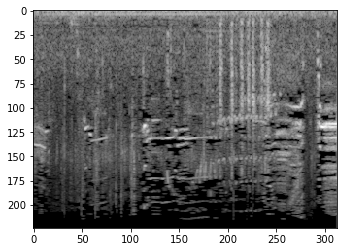

Label: tensor([52])


In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
idx = 3
img = train_features[idx].squeeze()
label = train_labels[idx]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model architecture

In [7]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ViT

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [8]:
class Time2Vec(nn.Module): # Positional Encoding layer
    
  def __init__(self, seq_len: int = 313):
    super().__init__()
    self.seq_len = seq_len
    
    bound = 1
        
    weights_linear = torch.Tensor(seq_len)
    self.weights_linear = nn.Parameter(weights_linear)
    nn.init.uniform_(self.weights_linear, -bound, bound)
    
    bias_linear = torch.Tensor(seq_len)
    self.bias_linear = nn.Parameter(bias_linear)
    nn.init.uniform_(self.bias_linear, -bound, bound)
    
    weights_periodic_1 = torch.Tensor(seq_len)
    self.weights_periodic_1 = nn.Parameter(weights_periodic_1)
    nn.init.uniform_(self.weights_periodic_1, -bound, bound)
    
    bias_periodic_1 = torch.Tensor(seq_len)
    self.bias_periodic_1 = nn.Parameter(bias_periodic_1)
    nn.init.uniform_(self.bias_periodic_1, -bound, bound)

    weights_periodic_2 = torch.Tensor(seq_len)
    self.weights_periodic_2 = nn.Parameter(weights_periodic_2)
    nn.init.uniform_(self.weights_periodic_2, -bound, bound)
    
    bias_periodic_2 = torch.Tensor(seq_len)
    self.bias_periodic_2 = nn.Parameter(bias_periodic_2)
    nn.init.uniform_(self.bias_periodic_2, -bound, bound)

    weights_periodic_3 = torch.Tensor(seq_len)
    self.weights_periodic_3 = nn.Parameter(weights_periodic_3)
    nn.init.uniform_(self.weights_periodic_3, -bound, bound)
    
    bias_periodic_3 = torch.Tensor(seq_len)
    self.bias_periodic_3 = nn.Parameter(bias_periodic_3)
    nn.init.uniform_(self.bias_periodic_3, -bound, bound)

  def forward(self, inputs): # where x has input shape (batch_size, channels, features, seq_len)
    x = torch.mean(inputs, dim = 2)
    x = x.squeeze()
    time_linear = self.weights_linear * x + self.bias_linear # (seq_len)
    time_periodic_1 = torch.sin(self.weights_periodic_1 * x + self.bias_periodic_1) # (seq_len)
    time_periodic_2 = torch.sin(self.weights_periodic_2 * x + self.bias_periodic_2) # (seq_len)
    time_periodic_3 = torch.sin(self.weights_periodic_3 * x + self.bias_periodic_3) # (seq_len)

    time_linear.unsqueeze_(1)
    time_periodic_1.unsqueeze_(1)
    time_periodic_2.unsqueeze_(1)
    time_periodic_3.unsqueeze_(1)

    out_time = torch.cat([time_linear, time_periodic_1, time_periodic_2, time_periodic_3], dim=1)
    out_time.unsqueeze_(1)
    out = torch.cat([inputs, out_time], dim = 2).squeeze().swapaxes(1, 2)
    return out # (batch_size, seq_len, features + 2)

x, _ = next(iter(train_dataloader))
layer = Time2Vec(seq_len = 313)
print(x.shape)
x = layer(x)
print(x.shape)

torch.Size([16, 1, 224, 313])
torch.Size([16, 313, 228])


In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 224, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

x, _ = next(iter(train_dataloader))
x_time = Time2Vec(seq_len = 313)(x)
MultiHeadAttention(emb_size = 228, num_heads = 12)(x_time).shape

torch.Size([16, 313, 228])

In [10]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 224,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 attention_drop_p: float = 0.,
                 num_heads: int = 8,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size,
                    dropout = attention_drop_p,
                    num_heads = num_heads,
                    **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
            )

x, _ = next(iter(train_dataloader))
x_time = Time2Vec(seq_len = 313)(x)
TransformerEncoderBlock(emb_size = 228, num_heads = 12)(x_time).shape

torch.Size([16, 313, 228])

In [11]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 224, n_classes: int = 152):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self,
                emb_size: int = 224,
                depth: int = 8,
                n_classes: int = 152,
                drop_p: float = 0.4,
                forward_expansion: int = 4,
                forward_drop_p: float = 0.4,
                attention_drop_p: float = 0.4,
                seq_len: int = 313,
                num_heads: int = 8,
                time_size: int = 4,
                **kwargs):
        super().__init__(
            Time2Vec(seq_len = seq_len),
            TransformerEncoder(depth,
                emb_size = emb_size + time_size,
                drop_p = drop_p,
                forward_expansion = forward_expansion,
                forward_drop_p = forward_drop_p,
                attention_drop_p = attention_drop_p,
                num_heads = num_heads,
                **kwargs),
            ClassificationHead((emb_size + time_size), n_classes)
        )


In [12]:
from torchsummary import summary

summary(ViT(emb_size = 224, num_heads = 12), (1, 224, 313), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Time2Vec-1             [-1, 313, 228]               0
         LayerNorm-2             [-1, 313, 228]             456
            Linear-3             [-1, 313, 684]         156,636
           Dropout-4         [-1, 12, 313, 313]               0
            Linear-5             [-1, 313, 228]          52,212
MultiHeadAttention-6             [-1, 313, 228]               0
           Dropout-7             [-1, 313, 228]               0
       ResidualAdd-8             [-1, 313, 228]               0
         LayerNorm-9             [-1, 313, 228]             456
           Linear-10             [-1, 313, 912]         208,848
             GELU-11             [-1, 313, 912]               0
          Dropout-12             [-1, 313, 912]               0
           Linear-13             [-1, 313, 228]         208,164
          Dropout-14             [-1, 3

## Training

In [13]:
import wandb
wandb.login()

wandb: Currently logged in as: kilian (use `wandb login --relogin` to force relogin)


True

## train best model

{'depth': 6,
 'drop_p': 0.2,
 'forward_expansion': 5,
 'forward_drop_p': 0.15000000000000002,
 'attention_drop_p': 0.55,
 'num_heads': 6,
 'learning_rate': 0.00020339617275110165}

In [14]:
# fixed params
n_classes = len(dataframe.primary_label.unique())
emb_size = 224
time_size = 4
seq_len = 313

# test params
depth = 6
drop_p = 0.2
forward_expansion = 3
forward_drop_p = 0.35
attention_drop_p = 0.55
num_heads = 6
lr = 0.00020339617275110165

config = {
"n_classes": n_classes,
"emb_size": emb_size,
"depth": depth,
"drop_p": drop_p,
"forward_expansion": forward_expansion,
"forward_drop_p": forward_drop_p,
"attention_drop_p": attention_drop_p,
"seq_len": seq_len,
"num_heads": num_heads,
"time_size": time_size, 
"do_feed_forward": False,
"learning_rate": lr
}

In [15]:
wandb.init(project="birdclef", config = config)

model = ViT(emb_size = config["emb_size"],
            depth = config["depth"],
            n_classes = config["n_classes"],
            drop_p = config["drop_p"],
            forward_expansion = config["forward_expansion"],
            forward_drop_p = config["forward_drop_p"],
            attention_drop_p = config["attention_drop_p"],
            seq_len = config["seq_len"],
            num_heads = config["num_heads"],
            time_size = config["time_size"]).to(device)

wandb.watch(model, log_freq=100)

optimizer = torch.optim.AdamW(model.parameters(), lr = config["learning_rate"])
criterion = nn.CrossEntropyLoss()

losses = []
val_losses = []
losses_epoch = []
val_losses_epoch = []

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
%%wandb
epochs = 10
for epoch in range(epochs):
    # train
    running_loss = 0.0
    running_loss_count = 0

    model.train()
    for inputs, labels in train_dataloader:
        if device.type == 'cuda':
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss)

        running_loss += loss.item()
        running_loss_count += 1

    losses_avrg = running_loss / running_loss_count
    losses_epoch.append(losses_avrg)
    wandb.log({"loss": losses_avrg})

    print(f'[{epoch + 1}] loss: {losses_avrg:.3f}')
    running_loss = 0.0
    running_loss_count = 0
    
    # validate
    val_running_loss = 0.0
    val_running_loss_count = 0
    model.eval()
   
    for inputs, labels in val_dataloader:
        if device.type == 'cuda':
            inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():
            target = model(inputs)
            val_loss = criterion(target, labels.squeeze())
            val_losses.append(val_loss)

            val_running_loss += val_loss.item()
            val_running_loss_count += 1

    losses_avrg_val = val_running_loss / val_running_loss_count
    val_losses_epoch.append(losses_avrg_val)
    wandb.log({"val_loss": losses_avrg_val})

    print(f'[{epoch + 1}] val loss: {losses_avrg_val:.3f}')
    val_running_loss = 0.0
    val_running_loss_count = 0

[1] loss: 2.480


wandb: Network error resolved after 0:01:16.254174, resuming normal operation.


[1] val loss: 1.842
[2] loss: 1.525
[2] val loss: 1.343
[3] loss: 1.108
[3] val loss: 1.110
[4] loss: 0.853
[4] val loss: 0.978
[5] loss: 0.681
[5] val loss: 0.892
[6] loss: 0.560
[6] val loss: 0.833
[7] loss: 0.470
[7] val loss: 0.844
[8] loss: 0.405
[8] val loss: 0.773
[9] loss: 0.353
[9] val loss: 0.801
[10] loss: 0.310
[10] val loss: 0.774


Text(0.5, 1.0, 'Transformer loss')

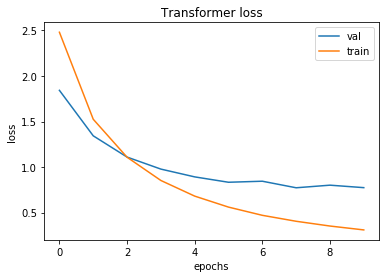

In [17]:
plt.plot(np.arange(len(val_losses_epoch)), val_losses_epoch, label = "val")
plt.plot(np.arange(len(losses_epoch)), losses_epoch, label = 'train')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Transformer loss")

In [18]:
correct = 0
for inputs, labels in val_dataloader:
    if device.type == 'cuda':
        inputs, labels = inputs.cuda(), labels.cuda()

    with torch.no_grad():
        output = model(inputs)
        _, idxs = output.topk(1, dim=1)
        correct += (idxs == labels).float().sum()

accuracy = 100 * correct / (len(val_dataloader) * batch_size)

print("Accuracy = {}".format(accuracy))

Accuracy = 82.37506866455078


In [19]:
summary(model, input_size = (1, 224, 313), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Time2Vec-1             [-1, 313, 228]               0
         LayerNorm-2             [-1, 313, 228]             456
            Linear-3             [-1, 313, 684]         156,636
           Dropout-4          [-1, 6, 313, 313]               0
            Linear-5             [-1, 313, 228]          52,212
MultiHeadAttention-6             [-1, 313, 228]               0
           Dropout-7             [-1, 313, 228]               0
       ResidualAdd-8             [-1, 313, 228]               0
         LayerNorm-9             [-1, 313, 228]             456
           Linear-10             [-1, 313, 684]         156,636
             GELU-11             [-1, 313, 684]               0
          Dropout-12             [-1, 313, 684]               0
           Linear-13             [-1, 313, 228]         156,180
          Dropout-14             [-1, 3

In [20]:
model_path = "models/transformer_v2.pt"
torch.save(model.state_dict(), model_path)